# The Ising Model

## Introduction

We begin with a finite, two-dimensional lattice $\Lambda \subset \mathbb{Z}^2$. Each point $i \in \Lambda$ on the lattice either has a spin (i.e. intrinsic magnetic moment) of $+1$ or $-1$. These spins observe the following properties:

1. The spins of each lattice point prefer to be in alignment with the external magnetic field $h$.


2. For ferromagnetic materials, spins prefer to be in alignment with their neighbors, i.e

   $$ H(\omega) = -\beta\sum_{\{i,j\} \in \epsilon_\Lambda}\omega_i \omega_j - h \sum_{i \in \Lambda}\omega_i.$$
   
   for a given microstate $\omega$ and a set of neighboring interactions $\epsilon_\Lambda = \{\{i, j\} : \lVert i - j \rVert = 1\}$.


3. For antiferromagnetic materials, spins prefer to be anti-parallel with their neighbors, i.e.

   $$ H(\omega) = \beta\sum_{\{i,j\} \in \epsilon_\Lambda}\omega_i \omega_j - h \sum_{i \in \Lambda}\omega_i.$$


The probability $\mu(\omega)$ of observing a particular microstate $\omega$ (i.e. the Gibbs distribution on the set of all microstates $\Omega$) is then given by the expression

$$ \mu(\omega) = \frac{1}{Z} e^{-H(\omega)},$$

where $Z$ is the canonical partition function.

The aim of the Ising model is to probe the dynamics, first-order phase transitions, and equilibrium structures of a ferromagnetic or antiferromagnetic material at varying temperatures and external magnetic fields.

## The Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is a Markov chain Monte Carlo numerical method that utilizes random sampling from a given proposal distribution to generate successively more probable equilibrium microstates of the Ising model. In the case of most models in statistical mechanics, this proposal distribution is the Gibbs distribution of the system. The Metropolis-Hastings algorithm selects a random point on the lattice, computes $\Delta E$ associated with inverting the spin, and generates a more probable lattice after each iteration.

* If $\Delta E < 0$, then the spin remains inverted.

* If $\Delta E \geq 0$, then the spin has a $e^{-\Delta E/T}$ probability of being inverted.

## Implementation for Ferromagnetic systems

First, we import the required libraries and initialize the basic functions generating, graphing, and iterating the lattice. The following code requires `numpy` and `pillow` to be installed. The visualizations denote lattice points with $+1$ spin by a white pixel, and lattice points with $-1$ spin by a black pixel.

In [38]:
#!/usr/bin/python

import numpy as np
from PIL import Image

def gen_lattice(N, M):
	return np.random.choice([-1, 1], size = (N, M))

def graph_lattice(lattice):
	return Image.fromarray(np.uint8((lattice + 1) * 0.5 * 255))

def compute_step(lattice, BETA, H):
	N = lattice.shape[0]
	M = lattice.shape[1]
	i = np.random.randint(N)
	j = np.random.randint(M)
	dE = test_flip(i, j, lattice, BETA, H)

	if (dE < 0):
		lattice[i][j] = - lattice[i][j]
	else:
		if (np.random.ranf() < np.exp(- dE * BETA)):
			lattice[i][j] = - lattice[i][j]
	return lattice

The `test_flip()` function called in the iterating `compute_step()` function computes the $\Delta E$ associated with inverting the spin of a random lattice point indexed by `i, j`. Note that as only a single spin is inverted, the expression for $\Delta E$ does not require computing the Hamiltonian of the entire lattice both before and after the inversion, but only the terms in the Hamiltonian affected by the inversion. The expression then reduces to

\begin{equation}
\Delta E = 2\beta (\omega_{ij}\omega_\textrm{top} + \omega_{ij}\omega_\textrm{bottom} + \omega_{ij}\omega_\textrm{left} + \omega_{ij}\omega_\textrm{right}) + 2h \omega_{ij}
\end{equation}

in the ferromagnetic case, where $\omega_\textrm{top},\omega_\textrm{bottom},\omega_\textrm{left},\omega_\textrm{right}$, are the spins of the lattice points directly adjacent to the inverted spin $\omega_{ij}$.

Also, note the usage of periodic boundary conditions. These greatly simplify computation of the Ising model while still preserving numerical accuracy with regards to real ferromagnetic/paramagnetic systems. The periodic boundary conditions result in the lattice being topologically equivalent to a torus.

<img src="figures/torus.png" width = "250" />

In [39]:
def test_flip(i, j, lattice, BETA, H):
	max_i = lattice.shape[0] - 1
	max_j = lattice.shape[1] - 1

	top = i - 1
	bottom = i + 1
	left = j - 1
	right = j + 1

	if (i == 0):
		top = max_i
	elif (i == max_i):
		bottom = 0

	if (j == 0):
		left = max_j
	elif (j == max_j):
		right = 0

	dE = 2 * BETA * lattice[i][j] * (lattice[top][j] + lattice[bottom][j] + lattice[i][left] + lattice[i][right]) + 2 * H * lattice[i][j]
	return dE

# Numerical Analysis

Now we begin numerical analysis of the Ising model. All studies begin with generating an initially random lattice as follows.

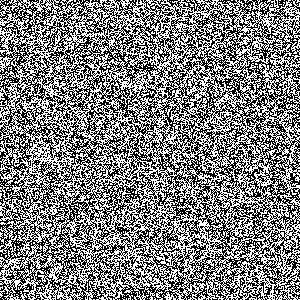

In [40]:
main_lattice = gen_lattice(300,300)
graph_lattice(main_lattice)

## Ferromagnetic systems where $h$ = 0

Let's see what happens after 1,000,000 iterations at very high temperatures, such that $\beta = 0.00001$.

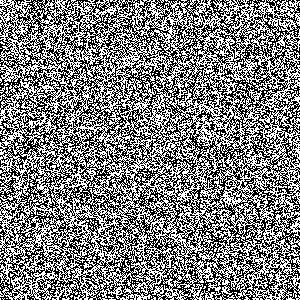

In [41]:
main_lattice = gen_lattice(300,300)
for i in range(1000000):
	main_lattice = compute_step(main_lattice, 0.00001, 0)
graph_lattice(main_lattice)

It seems that at high temperatures, the magnitude of thermal fluctuations grossly outweigh the stability conferred by spin alignment, and the randomly oriented lattice is more probable at higher temperatures. Similarly, let's see what happens after 1,000,000 iterations at very low temperatures, such that $\beta = 100000$.

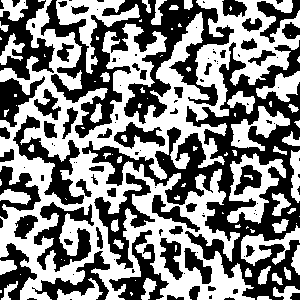

In [42]:
main_lattice = gen_lattice(300,300)
for i in range(1000000):
	main_lattice = compute_step(main_lattice, 100000, 0)
graph_lattice(main_lattice)

As expected, we observe a first-order phase transition as the system evolves from a random lattice, stable only at high temperature, to an ordered low temperature configuration. This is indicative of the temperature dropping below the Curie temperature $T_c$, after which the paramagnetic system evolves to a ferromagnetic system.

It turns out that given further iterations, the magnetic domains further broaden, and the lattice eventually becomes almost homogeneous throughout.

## Ferromagnetic systems where $h \neq$ 0

It is expected that $h \neq 0$ favors spins that are aligned with the field, and the net magnetization depends on the magnitude of the external magnetic field. Let us take $\beta = 100000$ and $h = 1$, after 100,000 iterations.

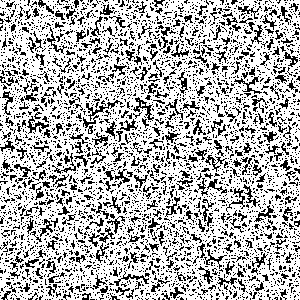

In [43]:
main_lattice = gen_lattice(300,300)
for i in range(100000):
	main_lattice = compute_step(main_lattice, 100000, 100)
graph_lattice(main_lattice)

## Extensibility to Antiferromagnetic systems

The code used above can be easily extended to antiferromagnetic systems just redefining how $\Delta E$ is computed. Taking notes from the introduction, we redefine the `test_flip()` function as follows.

In [44]:
def test_flip(i, j, lattice, BETA, H):
	max_i = lattice.shape[0] - 1
	max_j = lattice.shape[1] - 1

	top = i - 1
	bottom = i + 1
	left = j - 1
	right = j + 1

	if (i == 0):
		top = max_i
	elif (i == max_i):
		bottom = 0

	if (j == 0):
		left = max_j
	elif (j == max_j):
		right = 0
    
    # negative sign added here for antiferromagnetic systems
	dE = - 2 * BETA * lattice[i][j] * (lattice[top][j] + lattice[bottom][j] + lattice[i][left] + lattice[i][right]) + 2 * H * lattice[i][j]
	return dE

And let us perform 1,000,000 iterations under $\beta = 0.00001$ and $h = 0$.

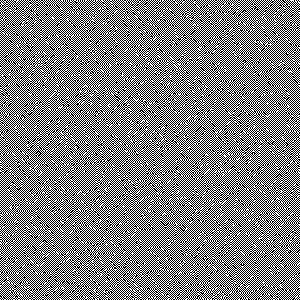

In [45]:
main_lattice = gen_lattice(300,300)
for i in range(1000000):
	main_lattice = compute_step(main_lattice, 10000, 0)
graph_lattice(main_lattice)